Imports

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

## Données
Charger les données

In [93]:
def _to_numeric_labels(y: pd.Series) -> pd.Series:
    y_num = pd.to_numeric(y, errors="raise")
    if (y_num.dropna() % 1 != 0).any():
        return y_num
    return y_num.astype(int)

In [94]:
def chargement_fichier(f):
    data = pd.read_csv("data/" + f, sep=r"\s+", engine="python", header=None)
    X = data.iloc[:, :-1].astype(float)
    y = _to_numeric_labels(data.iloc[:, -1])

    print("X shape :", X.shape)
    print("y shape :", y.shape)
    return X, y

Découpage de la base d'apprentissage

In [95]:
def decoupage_donnees(X, y, random_state=42):
    X_A, X_T, y_A, y_T = train_test_split(
        X, y, test_size=1/3, stratify=y, random_state=random_state
    )
    print("Taille apprentissage :", X_A.shape)
    print("Taille test :", X_T.shape)
    return X_A, X_T, y_A, y_T

Etiquettage

In [96]:
def rendre_partiellement_etiquete(X_A, y_A, pourcentage_labelise=30, random_state=42):
    if not (0 <= pourcentage_labelise <= 100):
        raise ValueError("pourcentage_labelise doit être entre 0 et 100")

    n = len(y_A)
    n_labelises = int(round((pourcentage_labelise / 100) * n))

    rng = np.random.default_rng(random_state)
    idx = np.arange(n)
    rng.shuffle(idx)
    idx_labelises = idx[:n_labelises]

    # float + NaN est parfait pour mask isna/notna
    y_partiel = pd.Series(np.nan, index=y_A.index, dtype=float)
    y_partiel.iloc[idx_labelises] = y_A.iloc[idx_labelises].astype(float).values

    return X_A, y_partiel

### Selection de variable semi-supervisée

Score de Fischer

In [97]:
import numpy as np
import pandas as pd

# Score de Fisher pour une variable v, calculé uniquement sur la partie labélisée.
def Sv1(X_A, y_partiel, v):
    # Récupérer la colonne v
    if isinstance(v, int):
        x = X_A.iloc[:, v]
    else:
        x = X_A[v]

    # Garder seulement la partie labélisée
    mask_lab = y_partiel.notna()
    x_lab = x.loc[mask_lab].astype(float)
    y_lab = y_partiel.loc[mask_lab]

    if len(y_lab) == 0:
        raise ValueError("Aucune donnée labélisée : impossible de calculer le score de Fisher.")
    
    classes = pd.unique(y_lab)
    if len(classes) < 2:
        raise ValueError("Il faut au moins 2 classes labélisées pour calculer un score de Fisher.")

    # Moyenne globale µ sur la partie labélisée
    mu = x_lab.mean()

    # Calcul du numérateur et du dénominateur
    numerateur = 0.0
    denominateur = 0.0

    for c in classes:
        x_c = x_lab[y_lab == c]
        ni = len(x_c)
        if ni == 0:
            continue

        mu_i = x_c.mean()
        # Ecart-type (population, ddof=0) ; si ni==1 => std=0
        sigma_i = x_c.std(ddof=0)

        numerateur += ni * (mu_i - mu) ** 2
        denominateur += ni * (sigma_i ** 2)

    # Éviter division par zéro
    if denominateur == 0:
        return float("inf") if numerateur > 0 else 0.0

    return numerateur / denominateur


Score Laplacien

In [98]:
import numpy as np
import pandas as pd

# Calcule Sv2(v) sur la partie NON labélisée de A.
def Sv2(X_A, y_partiel, v, t=10.0):
    # Sélection de la partie non labélisée
    mask_unlab = y_partiel.isna()
    X_U = X_A.loc[mask_unlab]
    if X_U.shape[0] < 2:
        raise ValueError("Il faut au moins 2 points non labélisés pour calculer Sv2.")

    # Récupérer la colonne v (sur non labélisé)
    if isinstance(v, int):
        vU = X_U.iloc[:, v].astype(float).to_numpy()
    else:
        vU = X_U[v].astype(float).to_numpy()

    # Variance de v sur non labélisé (population, ddof=0)
    var_v = float(np.var(vU, ddof=0))
    if var_v == 0.0:
        # si var(v)=0, la formule divise par 0 -> on renvoie 0 (ou inf selon ton choix)
        return 0.0

    # Matrices numpy
    Xmat = X_U.to_numpy(dtype=float)   # (n, d)
    n = Xmat.shape[0]

    # ||xi - xj||^2 = ||xi||^2 + ||xj||^2 - 2 xi.xj
    sq_norms = np.sum(Xmat * Xmat, axis=1, keepdims=True)  # (n,1)
    dist2 = sq_norms + sq_norms.T - 2.0 * (Xmat @ Xmat.T)  # (n,n)
    dist2 = np.maximum(dist2, 0.0)  # sécurité numérique

    # Sij
    S = np.exp(-dist2 / float(t))  # (n,n)

    # (vi - vj)^2
    dv2 = (vU.reshape(-1, 1) - vU.reshape(1, -1)) ** 2  # (n,n)

    numerateur = float(np.sum(dv2 * S))
    return numerateur / var_v


Score final

In [99]:
def scoreFinal(X_A, y_partiel, v, t=10.0, eps=1e-12):
    scoreFischer = Sv1(X_A, y_partiel, v)
    scoreLaplace = Sv2(X_A, y_partiel, v, t=t)

    # éviter division par 0 (si Sv2=0)
    if scoreLaplace == 0.0:
        return float("inf") if scoreFischer > 0 else 0.0

    return scoreFischer / (scoreLaplace + eps)

### Evaluation de la sélection

In [100]:
def trier_variables_par_pertinence(X_A, y_partiel, t=10.0, eps=1e-12):
    scores = np.array(
        [scoreFinal(X_A, y_partiel, v, t=t, eps=eps) for v in range(X_A.shape[1])],
        dtype=float
    )
    order = np.argsort(-scores)
    classement = [(int(i), float(scores[i])) for i in order]
    return classement, scores

Efficacité

In [101]:
# ============================================================
# MLP helper
# ============================================================
def _make_mlp_pipeline(normalize=True, hidden_layer_sizes=(100,), max_iter=1000, random_state=42):
    steps = [("imputer", SimpleImputer(strategy="median"))]
    if normalize:
        steps.append(("scaler", StandardScaler()))
    steps.append(("mlp", MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        max_iter=max_iter,
        random_state=random_state
    )))
    return Pipeline(steps)


# ============================================================
# Courbes efficacité (LOGIQUE)
# ============================================================
def courbe_efficacite_mlp_topk(
    X_A, y_A_partiel, X_T, y_T, var_order,
    pas=5, normalize=True,
    hidden_layer_sizes=(100,), max_iter=1000, random_state=42
):
    """
    Courbe accuracy sur T en fonction du nombre de variables (top-k selon var_order),
    k = pas, 2*pas, ..., d (et d à la fin).
    """
    mask_lab = y_A_partiel.notna()
    X_train_full = X_A.loc[mask_lab]
    y_train = y_A_partiel.loc[mask_lab].astype(int)

    if y_train.nunique() < 2:
        raise ValueError("Pas assez de classes dans la partie labélisée. Augmente % labélisées.")

    y_T_int = pd.to_numeric(y_T, errors="raise").astype(int)

    d = len(var_order)
    ks = list(range(pas, d + 1, pas))
    if len(ks) == 0:
        ks = [d]
    elif ks[-1] != d:
        ks.append(d)

    accs = []
    for k in ks:
        selected = var_order[:k]

        Xtr = X_train_full.iloc[:, selected]
        Xte = X_T.iloc[:, selected]

        model = _make_mlp_pipeline(
            normalize=normalize,
            hidden_layer_sizes=hidden_layer_sizes,
            max_iter=max_iter,
            random_state=random_state
        )
        model.fit(Xtr, y_train)
        pred = model.predict(Xte)
        accs.append(float(accuracy_score(y_T_int, pred)))

    return ks, accs


def point_efficacite_sans_selection(
    X_A, y_A_partiel, X_T, y_T,
    normalize=True,
    hidden_layer_sizes=(100,), max_iter=1000, random_state=42
):
    """
    Un seul point: entraînement sur toutes les variables (pas de sélection).
    Retourne x=[d], y=[acc].
    """
    mask_lab = y_A_partiel.notna()
    X_train = X_A.loc[mask_lab]
    y_train = y_A_partiel.loc[mask_lab].astype(int)

    if y_train.nunique() < 2:
        raise ValueError("Pas assez de classes dans la partie labélisée. Augmente % labélisées.")

    y_T_int = pd.to_numeric(y_T, errors="raise").astype(int)

    model = _make_mlp_pipeline(
        normalize=normalize,
        hidden_layer_sizes=hidden_layer_sizes,
        max_iter=max_iter,
        random_state=random_state
    )
    model.fit(X_train, y_train)
    pred = model.predict(X_T)
    acc = float(accuracy_score(y_T_int, pred))

    return [X_A.shape[1]], [acc]


def courbe_perf_vs_pourcentage_labels_kfix(
    filename,
    pourcentages,
    nb_vars_fix=20,
    t=10.0,
    random_state=42,
    normalize=True,
    hidden_layer_sizes=(100,), max_iter=1000
):
    """
    Fixe nb_vars_fix (=20) et calcule la perf (accuracy sur T) en fonction du % labélisé.
    Recalcule le classement à chaque % (car dépend des labels).
    """
    # dépend de ton code existant :
    # chargement_fichier, decoupage_donnees, rendre_partiellement_etiquete, trier_variables_par_pertinence
    X, y = chargement_fichier(filename)
    X_A, X_T, y_A, y_T = decoupage_donnees(X, y, random_state=random_state)

    xs, ys = [], []
    y_T_int = pd.to_numeric(y_T, errors="raise").astype(int)

    for p in pourcentages:
        _, y_A_partiel = rendre_partiellement_etiquete(
            X_A, y_A, pourcentage_labelise=p, random_state=random_state
        )

        classement, _ = trier_variables_par_pertinence(X_A, y_A_partiel, t=t)
        var_order = [vid for (vid, _) in classement]
        k = min(nb_vars_fix, len(var_order))
        selected = var_order[:k]

        mask_lab = y_A_partiel.notna()
        X_train = X_A.loc[mask_lab].iloc[:, selected]
        y_train = y_A_partiel.loc[mask_lab].astype(int)

        # si 1 seule classe, accuracy pas pertinente -> NaN
        if y_train.nunique() < 2:
            xs.append(p)
            ys.append(np.nan)
            continue

        X_test = X_T.iloc[:, selected]

        model = _make_mlp_pipeline(
            normalize=normalize,
            hidden_layer_sizes=hidden_layer_sizes,
            max_iter=max_iter,
            random_state=random_state
        )
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        acc = float(accuracy_score(y_T_int, pred))

        xs.append(p)
        ys.append(acc)

    return xs, ys

Plot

In [102]:
import matplotlib.pyplot as plt

# ============================================================
# PLOT HELPERS
# ============================================================
def plot_une_courbe(x, y, label, title, xlabel, ylabel):
    plt.figure(figsize=(8, 4))
    plt.plot(x, y, marker="o", label=label)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_un_point(x, y, label, title, xlabel, ylabel):
    plt.figure(figsize=(8, 4))
    plt.scatter(x, y, label=label)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, linestyle="--", linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_toutes_courbes_sur_un_graphe(curves_k, curve_pct_labels_kfix, kfix):
    """
    curves_k: dict name -> (x, y)  où x = nb variables, y = accuracy
    curve_pct_labels_kfix: (xp, yp) où xp = % labélisé, yp = accuracy
    Trace un seul graphe final avec 2 axes Y.
    """
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Courbes "nb variables" (axe gauche)
    for name, (x, y) in curves_k.items():
        # points (liste de taille 1) => scatter
        if len(x) == 1:
            ax1.scatter(x, y, label=name)
        else:
            ax1.plot(x, y, marker="o", label=name)

    ax1.set_xlabel("Nombre de variables sélectionnées (top-k)")
    ax1.set_ylabel("Accuracy sur T")
    ax1.grid(True, linestyle="--", linewidth=0.5)

    # Courbe "% labélisé" (axe droit)
    xp, yp = curve_pct_labels_kfix
    ax2 = ax1.twinx()
    ax2.plot(xp, yp, marker="o", linestyle="--", label=f"Top-{kfix} vs % labélisé")
    ax2.set_ylabel("Accuracy sur T (courbe % labélisé)")

    # Légende combinée
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

    plt.title("Toutes les courbes d'efficacité (MLP)")
    plt.tight_layout()
    plt.show()


Pipeline

In [103]:

# ============================================================
# PIPELINE (calcule + plot au fur et à mesure + plot final)
# ============================================================
def pipeline_plots_efficacite(
    filename,
    pourcentage_labelise=30,
    t=10.0,
    pas=5,
    nb_vars_fix=20,
    pourcentages_labels=None,
    random_state=42,
    hidden_layer_sizes=(100,),
    max_iter=1000
):
    """
    Dépend de tes fonctions existantes :
    - chargement_fichier
    - decoupage_donnees
    - rendre_partiellement_etiquete
    - trier_variables_par_pertinence
    - courbe_efficacite_mlp_topk
    - point_efficacite_sans_selection
    - courbe_perf_vs_pourcentage_labels_kfix
    """
    if pourcentages_labels is None:
        pourcentages_labels = [5, 10, 20, 30, 40, 60, 80, 100]

    # 0) Data + split
    X, y = chargement_fichier(filename)
    X_A, X_T, y_A, y_T = decoupage_donnees(X, y, random_state=random_state)

    # 1) Partiellement labélisé
    _, y_A_partiel = rendre_partiellement_etiquete(
        X_A, y_A, pourcentage_labelise=pourcentage_labelise, random_state=random_state
    )

    # 2) Classement pertinence
    classement, _ = trier_variables_par_pertinence(X_A, y_A_partiel, t=t)
    var_order_pert = [vid for (vid, _) in classement]
    var_order_nonpert = list(reversed(var_order_pert))

    curves_k = {}

    # A) Courbe pertinentes normalisées
    x, yv = courbe_efficacite_mlp_topk(
        X_A, y_A_partiel, X_T, y_T, var_order_pert,
        pas=pas, normalize=True,
        hidden_layer_sizes=hidden_layer_sizes, max_iter=max_iter, random_state=random_state
    )
    curves_k["Pertinentes (normalisées)"] = (x, yv)
    plot_une_courbe(
        x, yv,
        label="Pertinentes (normalisées)",
        title="Courbe d'efficacité (top-k pertinentes, normalisées)",
        xlabel="Nombre de variables (k)",
        ylabel="Accuracy sur T"
    )

    # B) Courbe pertinentes non-normalisées
    x, yv = courbe_efficacite_mlp_topk(
        X_A, y_A_partiel, X_T, y_T, var_order_pert,
        pas=pas, normalize=False,
        hidden_layer_sizes=hidden_layer_sizes, max_iter=max_iter, random_state=random_state
    )
    curves_k["Pertinentes (non-normalisées)"] = (x, yv)
    plot_une_courbe(
        x, yv,
        label="Pertinentes (non-normalisées)",
        title="Courbe d'efficacité (top-k pertinentes, non-normalisées)",
        xlabel="Nombre de variables (k)",
        ylabel="Accuracy sur T"
    )

    # C) Courbe non-pertinentes normalisées
    x, yv = courbe_efficacite_mlp_topk(
        X_A, y_A_partiel, X_T, y_T, var_order_nonpert,
        pas=pas, normalize=True,
        hidden_layer_sizes=hidden_layer_sizes, max_iter=max_iter, random_state=random_state
    )
    curves_k["Non-pertinentes (normalisées)"] = (x, yv)
    plot_une_courbe(
        x, yv,
        label="Non-pertinentes (normalisées)",
        title="Courbe d'efficacité (top-k non-pertinentes, normalisées)",
        xlabel="Nombre de variables (k)",
        ylabel="Accuracy sur T"
    )

    # D) Sans sélection (toutes variables) norm + non-norm (points)
    x, yv = point_efficacite_sans_selection(
        X_A, y_A_partiel, X_T, y_T,
        normalize=True,
        hidden_layer_sizes=hidden_layer_sizes, max_iter=max_iter, random_state=random_state
    )
    curves_k["Sans sélection (toutes vars, norm)"] = (x, yv)
    plot_un_point(
        x, yv,
        label="Sans sélection (norm)",
        title="Sans sélection de variables (toutes variables, normalisées)",
        xlabel="Nombre de variables",
        ylabel="Accuracy sur T"
    )

    x, yv = point_efficacite_sans_selection(
        X_A, y_A_partiel, X_T, y_T,
        normalize=False,
        hidden_layer_sizes=hidden_layer_sizes, max_iter=max_iter, random_state=random_state
    )
    curves_k["Sans sélection (toutes vars, non-norm)"] = (x, yv)
    plot_un_point(
        x, yv,
        label="Sans sélection (non-norm)",
        title="Sans sélection de variables (toutes variables, non-normalisées)",
        xlabel="Nombre de variables",
        ylabel="Accuracy sur T"
    )

    # E) Performance vs % labélisé (k fixé)
    xp, yp = courbe_perf_vs_pourcentage_labels_kfix(
        filename=filename,
        pourcentages=pourcentages_labels,
        nb_vars_fix=nb_vars_fix,
        t=t,
        random_state=random_state,
        normalize=True,
        hidden_layer_sizes=hidden_layer_sizes,
        max_iter=max_iter
    )
    plot_une_courbe(
        xp, yp,
        label=f"Top-{nb_vars_fix} vs % labélisé",
        title=f"Performance vs % labélisé (k={nb_vars_fix})",
        xlabel="% labélisé dans A",
        ylabel="Accuracy sur T"
    )

    # F) Plot final: tout sur un graphe
    plot_toutes_courbes_sur_un_graphe(curves_k, (xp, yp), kfix=nb_vars_fix)

    return {
        "curves_k": curves_k,
        "curve_pct_labels_kfix": (xp, yp),
        "classement": classement
    }

X shape : (5000, 40)
y shape : (5000,)
Taille apprentissage : (3333, 40)
Taille test : (1667, 40)


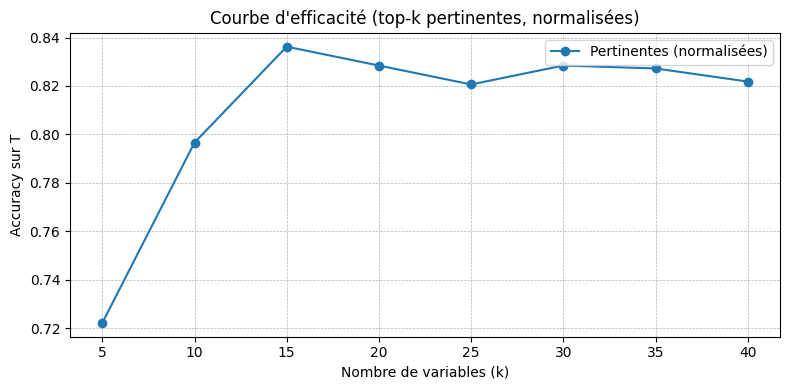

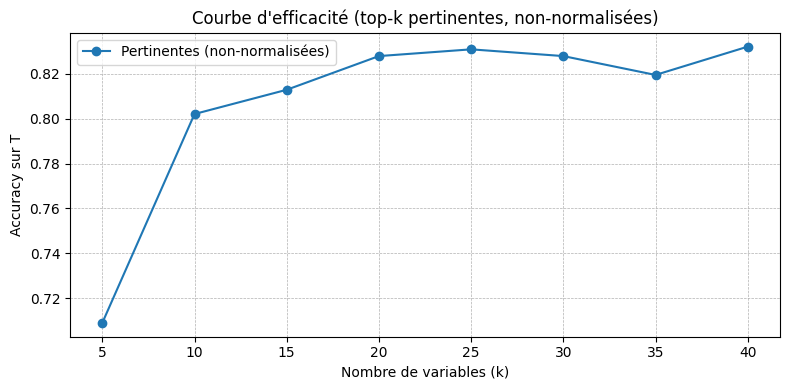

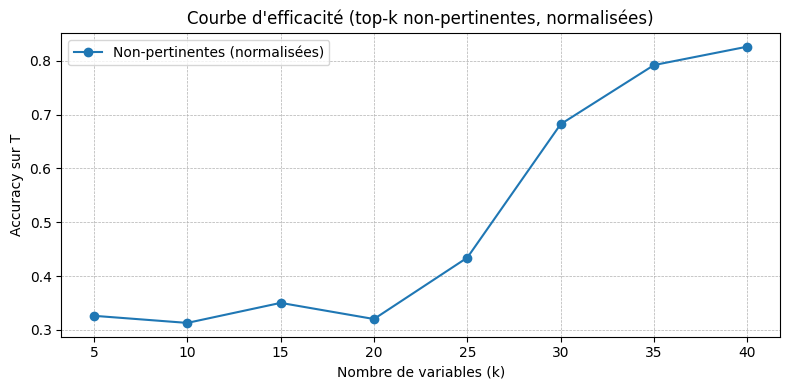

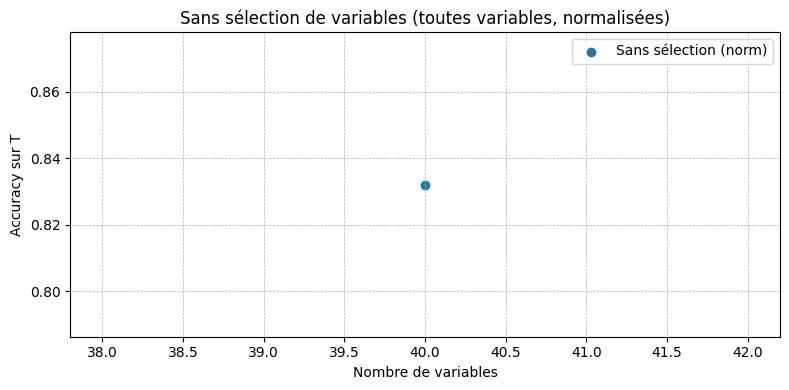

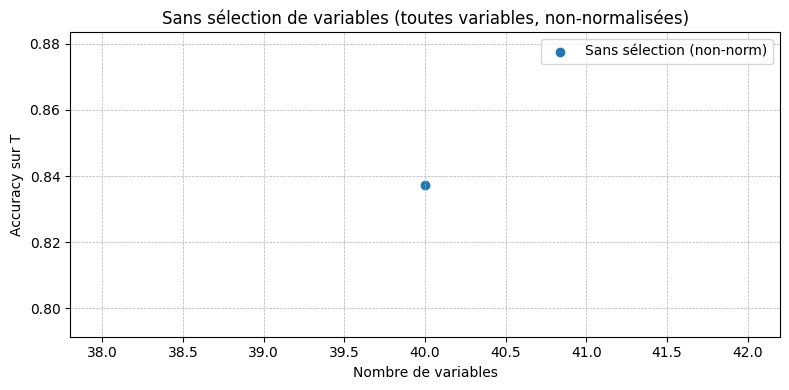

X shape : (5000, 40)
y shape : (5000,)
Taille apprentissage : (3333, 40)
Taille test : (1667, 40)


ValueError: Il faut au moins 2 points non labélisés pour calculer Sv2.

In [104]:
out = pipeline_plots_efficacite(filename="wave.txt")